In [1]:
import pandas as pd
try:
  import xml.etree.cElementTree as et
except ImportError:
  import xml.etree.ElementTree as et
import numpy as np   
import math
from sklearn.model_selection import KFold
import scipy
import os

K_DEPTH_VIEW = 30
K_DEPTH_SAT = 5
MAX_REL = 5
MED_REL = 3

In [3]:
'''
Code for Parsing THUIR2 -
'''
DATA_FILE = "data/THUIR2/search_logs.xml"
REL_FILE = "data/THUIR2/relevance_annotation.tsv"

myParser = et.XMLParser(encoding="utf-8")
tree = et.parse(DATA_FILE, parser=myParser)
root = tree.getroot()

In [5]:
'''
Read tsv data
'''
rel_data = pd.read_csv(REL_FILE, sep = '\t', header = 0, encoding='utf-8')

'''
Read XML data
'''
parsed_log = []
for session in root.iter("session"): 
    session_id = session.get("num")
    query_id = ""
    for query in session.iter("interaction"):
        page_id = query.get("page_id")
        if page_id == "1":
            if query_id:
                # Add record to log
                parsed_log.append({"id":session_id+"-"+query_id, "query": query_text, "result":query_result, "sat":query_sat, "nc": nc, "dc": dc}) 
            query_id = query.get("num")
            query_text = query.find("query").text
            query_result = []
            query_sat = query.find("query_satisfaction").get("score")
            nc = 0 # number of clicks
            dc = 0 # deepest click
        current_result = query.find("results")
        current_click = query.find("clicked")
        for result in current_result:
            doc_id = result.find("id").text
            doc_rank = result.get("rank")
            rel = rel_data[rel_data['docno'] == int(doc_id)]
            if len(rel):
                doc_rel = rel.iloc[0, 3]
            else:
                doc_rel = 0
            query_result.append(doc_rel)
        if current_click:
            for click in current_click:
                nc += 1
                dc = click.find('rank').text
    # Add record to log
    parsed_log.append({"id":session_id+"-"+query_id, "query": query_text, 'SERPs': [{'top10_usefulness':query_result}], 'satisfaction':query_sat, "nc": nc, "dc": dc}) 
    
print(parsed_log[100])


{'id': '38-5', 'query': '港版 iphone6关税 ', 'result': [3, 2, 3, 2, 2, 0, 0, 0, 0, 0], 'sat': '4', 'nc': 1, 'dc': '0'}


In [4]:
def s_insq(x):
    res = 0
    for i in range(1, x+1):
        res += 1/i**2
    return math.pi**2 / 6 - res

def gain(rel):
    return rel

def gain_err(rel):
    return (2**rel - 1)/2**MAX_REL

# The probability users view the document at rank n
# Supposed they always view the first document
def decay_dcg (b, n):
    return 1.0/(1+ math.log(n,b))

def v_rbp(p, n):
    return p**(n-1)

def v_insq(t, n, last_prob):
    if n == 1:
        return 1
    else:
        return last_prob * ((n + 2*t - 2)/(n + 2*t -1))**2
    
def v_inst(t, n, cr, last_prob):
    if last_prob <= 0:
        return 0
    
    if n == 1:
        return 1
    else:
        tn = t - cr
        v = last_prob * ((n + t + tn - 2)/(n + t + tn - 1))**2
        if v > 0:
            return v
        else:
            return 0
        
def w_rbp(p, n):
    return (1-p) * (p**(n-1))

def w_err(rank, last_prob):
    return (1.0/rank) * last_prob

def w_p():
    return 1/K_DEPTH_SAT 

def w_insq(t, n):
    return (1/s_insq(2*t-1)) * (1/(n + 2*t - 1)**2)

def w_inst(t, n, cr):
    w = 1/(s_insq(2*t-1))*(1/(n + 2*t - cr -1)**2)
    if w > 0:
         return w
    else:
        return 0
    
    

In [7]:
DCG_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
RBP_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
INSQ_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
INST_MODE = {'BEHAVIOUR':'ub', 'SATISFACTION':'us'}
METRIC = {'DCG':'dcg', 'RBP':'rbp', 'ERR':'err', 'P':'p', 'INSQ':'insq', 'INST':'inst'}

'''
RQ1 - How to issue a new framework incorporating the anchoring effect into IR metrics
'''

def default_run(pm, result_list, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    res = 0
    last_prob = 1.0 # For ERR
    cr = 0 # For INST
    for doc in result_list:
        if int(doc['doc_rank'])< K_DEPTH_SAT:
            cur_rel = int(doc['doc_rel'])
            cur_rank = int(doc['doc_rank'])+1
            if metric == 'DCG':
                cur_gain = gain(cur_rel)*decay_dcg(pm, cur_rank)
            elif metric == 'RBP':
                cur_gain = gain(cur_rel)*w_rbp(pm, cur_rank)
            elif metric == 'ERR':
                cur_gain = gain_err(cur_rel)*w_err(cur_rank, last_prob)
                last_prob *= (1- gain_err(cur_rel))
            elif metric == 'P':
                cur_gain = gain(cur_rel)*w_p()
            elif metric == 'INSQ':
                cur_gain = gain(cur_rel) * w_insq(pm, cur_rank)
            elif metric == 'INST':
                cur_gain = gain(cur_rel) * w_inst(pm, cur_rank, cr)
                cr += cur_rel/MAX_REL
            res += cur_gain
    return res

def AEM_run(pm, l, k,result_list, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    res = 0.0
    last_rel = -1.0
    # For ERR
    last_prob = 1.0
    # For INST
    cr = 0
    for doc in result_list:
        cur_rank = int(doc['doc_rank']) + 1
        if cur_rank <= K_DEPTH_SAT:
            # First doc
            if cur_rank == 1:
                cur_rel = int(doc['doc_rel'])
            else:
                x = (last_rel - MED_REL)/(MAX_REL-MED_REL)
                a = l / (k + math.exp(-(1/k)*(x)))
                if a > l:
                    a = l
                cur_rel = a*last_rel + (1-a)*int(doc['doc_rel'])
                
            # We assume that users assess documents objectively, 
            # but their gain from the current document is affected by the quality of the last document
            if metric == 'DCG':
                cur_gain = gain(cur_rel)*decay_dcg(pm, cur_rank)
            elif metric == 'RBP':
                cur_gain = gain(cur_rel)*w_rbp(pm, cur_rank)
            elif metric == 'ERR':
                cur_gain = gain_err(cur_rel)*w_err(cur_rank, last_prob)
                last_prob *= (1-gain_err(cur_rel))
            elif metric == 'P':
                cur_gain =  gain(cur_rel)*w_p()
            elif metric == 'INSQ':
                cur_gain = gain(cur_rel) * w_insq(pm, cur_rank)
            elif metric == 'INST':
                cur_gain = gain(cur_rel)*w_inst(pm, cur_rank, cr)
                cr += cur_rel/MAX_REL
        else:
            break
        res += cur_gain
        # Real Quality
        last_rel = int(doc['doc_rel'])
        #last_rel = cur_rel
    #print(res)
    return res
        
def compute_TSE(train_set, metric, pm):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    tse = 0
    last_prob = 1 # For INSQ & INST
    cr = 0 # For INST
    for q in train_set:
        dc = int(q['dc'])
        nc = int(q['nc'])
        for rank in range(1, K_DEPTH_VIEW+1):
            if metric == 'DCG':
                p_dr_hat = decay_dcg(pm, rank)
            elif metric == 'RBP':
                p_dr_hat = v_rbp(pm, rank)
            elif metric == 'INSQ':
                p_dr_hat = v_insq(pm, rank, last_prob)
                last_prob *= p_dr_hat
            # We assume that the relevance of documents 
            # at depth larger than assessment depth is 0
            elif metric == 'INST':
                if rank <= K_DEPTH_SAT:
                    cur_rel = int(q['result'][rank-1]['doc_rel'])
                else:
                    cur_rel = 0
                p_dr_hat = v_inst(pm, rank, cr, last_prob)
                last_prob *= p_dr_hat
                cr += cur_rel/MAX_REL
                
            if rank <= dc:
                p_dr = 1
            else:
                n = rank - dc
                #k = 5.1 + dc* 0.29 - nc*0.14 # Wickasono(2021) Model2
                k = 3.48 - dc* 0.46 + nc * 0.2  # Wickasono(2020) for THUIR1
                if(k < 0):
                    p_dr = 0
                else:
                    p_dr = math.exp((-1.0*n)/k)
            tse += (p_dr_hat - p_dr)**2
            
    return tse
        
'''
Grid Search for DCG
'''
def train_dcg_baseline(train_set, mode):
    if mode not in DCG_MODE:
        raise Exception('No such mode: %s'%(mode))
    
    dcg_b={}   
    for b in np.arange(1.1, 5.01, 0.1):
        b = round(b, 2)
        if mode == 'BEHAVIOUR':
            dcg_b[b] = compute_TSE(train_set, 'DCG', b)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(b, q['result'],  'DCG') for q in train_set]
            dcg_b[b] = scipy.stats.spearmanr(X, Y).correlation
    
    if mode == 'BEHAVIOUR':
        b_st = min(dcg_b, key = dcg_b.get)
    elif mode == 'SATISFACTION':
        b_st = max(dcg_b, key = dcg_b.get)
        
    return b_st


'''
Grid Search for RBP
'''
def train_rbp_baseline(train_set, mode):
    if mode not in RBP_MODE:
        raise Exception('No such mode: %s'%(mode))
        
    rbp_p = {}
    for p in np.arange(0, 1.01, 0.05):
        p = round(p, 2)
        if mode == 'BEHAVIOUR':
            rbp_p[p] = compute_TSE(train_set, 'RBP', p)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(p, q['result'], 'RBP') for q in train_set]
            rbp_p[p] = scipy.stats.spearmanr(X, Y).correlation
            
    if mode == 'BEHAVIOUR':
        p_st = min(rbp_p, key = rbp_p.get)
    elif mode == 'SATISFACTION':
        p_st = max(rbp_p, key = rbp_p.get)
        
    return p_st
        
'''
Grid Search for INSQ
'''
def train_insq_baseline(train_set, mode):
    if mode not in INSQ_MODE:
        raise Exception('No such mode: %s'%(mode))
        
    insq_t = {}
    for t in range(1, 25):
        if mode == 'BEHAVIOUR':
            insq_t[t] = compute_TSE(train_set, 'INSQ', t)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(t, q['result'], 'INSQ') for q in train_set]
            insq_t[t] = scipy.stats.spearmanr(X, Y).correlation
            
    if mode == 'BEHAVIOUR':
        t_st = min(insq_t, key = insq_t.get)
    elif mode == 'SATISFACTION':
        t_st = max(insq_t, key = insq_t.get)
        
    return t_st

        
'''
Grid Search for INST
'''
def train_inst_baseline(train_set, mode):
    if mode not in INST_MODE:
        raise Exception('No such mode: %s'%(mode))
        
    inst_t = {}
    for t in range(1, 25):
        if mode == 'BEHAVIOUR':
            inst_t[t] = compute_TSE(train_set, 'INST', t)
        elif mode == 'SATISFACTION':
            Y = [float(q['sat']) for q in train_set]
            X = [default_run(t, q['result'], 'INST') for q in train_set]
            inst_t[t] = scipy.stats.spearmanr(X, Y).correlation
            
    if mode == 'BEHAVIOUR':
        t_st = min(inst_t, key = inst_t.get)
    elif mode == 'SATISFACTION':
        t_st = max(inst_t, key = inst_t.get)
        
    return t_st

'''
Grid Search for Callibrating lambda and kappa for AEMs
'''

def train_AEM(pm, train_set, metric):
    if metric not in METRIC:
        raise Exception('No such metric: %s'%(metric))
    map_aem = {}
    Y = [float(q['sat']) for q in train_set]
    for l in np.arange(0, 1.01, 0.1):
        l = round(l, 3)
        for k in np.arange(0, 0.501, 0.05):
            k = round(k, 4)
            if metric == 'DCG':
                X = [AEM_run(pm, l, k, q['result'], 'DCG') for q in train_set]
            elif metric == 'RBP':
                X = [AEM_run(pm, l, k, q['result'], 'RBP') for q in train_set]
            elif metric == 'ERR':
                X =  [AEM_run(pm, l, k, q['result'], 'ERR') for q in train_set]
            elif metric == 'P':
                X =  [AEM_run(pm, l, k, q['result'], 'P') for q in train_set]
            elif metric == 'INSQ':
                X =  [AEM_run(pm, l, k, q['result'], 'INSQ') for q in train_set]
            elif metric == 'INST':
                X =  [AEM_run(pm, l, k, q['result'], 'INST') for q in train_set]
            if not(l in map_aem):
                map_aem[l] = {}
            map_aem[l][k] = scipy.stats.spearmanr(X, Y).correlation
    # Find best parameter   
    r = -1
    l_st = -1
    k_st = -1
    for l in map_aem:
        for k in map_aem[l]:
            if map_aem[l][k] > r:
                r = map_aem[l][k]
                l_st = l
                k_st = k
    return (l_st, k_st)


In [8]:
rl_dcg_b = []
rl_dcg_s = []
rl_dcg_AEM = []

rl_rbp_b = []
rl_rbp_s = []
rl_rbp_AEM = []

rl_err = []
rl_err_AEM = []

rl_p = []
rl_p_AEM = []

rl_insq_b = []
rl_insq_s = []
rl_insq_AEM = []

rl_inst_b = []
rl_inst_s = []
rl_inst_AEM = []

l1s = []
k1s = []
bbs = []
bss = []

l2s = []
k2s = []
pbs = []
pss = []

l3s = []
k3s = []

l4s = []
k4s = []

l5s = []
k5s = []
t1bs = []
t1ss = []

l6s = []
k6s = []
t2bs = []
t2ss = []

tt = 0

for i in range(0, 10):
    kf = KFold(n_splits=5,shuffle=True)
    for train_index , test_index in kf.split(parsed_log): 
        tt+=1
        print('training: %s'%(tt))
        train_set = [parsed_log[i] for i in train_index]
        test_set = [parsed_log[i] for i in test_index]

        b_b = train_dcg_baseline(train_set, 'BEHAVIOUR')
        b_s = train_dcg_baseline(train_set, 'SATISFACTION')
        l_1, k_1 = train_AEM(b_b, train_set, 'DCG')
        l1s.append(l_1)
        k1s.append(k_1)
        bbs.append(b_b)
        bss.append(b_s)
        
        p_b = train_rbp_baseline(train_set, 'BEHAVIOUR')
        p_s = train_rbp_baseline(train_set, 'SATISFACTION')
        l_2, k_2 = train_AEM(p_b, train_set, 'RBP')
        l2s.append(l_2)
        k2s.append(k_2)
        pbs.append(p_b)
        pss.append(p_s)
        
        l_3, k_3 = train_AEM(-1, train_set, 'ERR')
        l3s.append(l_3)
        k3s.append(k_3)
        
        l_4, k_4 = train_AEM(-1, train_set, 'P')
        l4s.append(l_4)
        k4s.append(k_4)
        
        t1_b = train_insq_baseline(train_set, 'BEHAVIOUR')
        t1_s = train_insq_baseline(train_set, 'SATISFACTION')
        l_5, k_5 = train_AEM(t1_b, train_set, 'INSQ')
        l5s.append(l_5)
        k5s.append(k_5)
        t1bs.append(t1_b)
        t1ss.append(t1_s)
        
        t2_b = train_inst_baseline(train_set, 'BEHAVIOUR')
        t2_s = train_inst_baseline(train_set, 'SATISFACTION')
        l_6, k_6 = train_AEM(t2_b, train_set, 'INST')
        l6s.append(l_6)
        k6s.append(k_6)
        t2bs.append(t2_b)
        t2ss.append(t2_s)
        
        X_dcg_b = [default_run(b_b, q['result'], 'DCG') for q in test_set]
        X_dcg_s = [default_run(b_s, q['result'], 'DCG') for q in test_set]
        X_dcg_AEM = [AEM_run(b_b, l_1 , k_1, q['result'], 'DCG') for q in test_set]
        
        X_rbp_b = [default_run(p_b, q['result'], 'RBP') for q in test_set]
        X_rbp_s = [default_run(p_s, q['result'], 'RBP') for q in test_set]
        X_rbp_AEM = [AEM_run(p_b, l_2 , k_2, q['result'], 'RBP') for q in test_set]
        
        X_err = [default_run(-1, q['result'], 'ERR')  for q in test_set]
        X_err_AEM = [AEM_run(-1, l_3 , k_3, q['result'], 'ERR') for q in test_set]
        
        X_p = [default_run(-1, q['result'], 'P')  for q in test_set]
        X_p_AEM = [AEM_run(-1, l_4 , k_4, q['result'], 'P') for q in test_set]
        
        X_insq_b = [default_run(t1_b, q['result'], 'INSQ') for q in test_set]
        X_insq_s = [default_run(t1_s, q['result'], 'INSQ') for q in test_set]
        X_insq_AEM = [AEM_run(t1_b, l_5 , k_5, q['result'], 'INSQ') for q in test_set]
        
        X_inst_b = [default_run(t2_b, q['result'], 'INST') for q in test_set]
        X_inst_s = [default_run(t2_s, q['result'], 'INST') for q in test_set]
        X_inst_AEM = [AEM_run(t2_b, l_6 , k_6, q['result'], 'INST') for q in test_set]
        
        Y = [float(q['sat']) for q in test_set]
        
        rl_dcg_b.append(scipy.stats.spearmanr(X_dcg_b, Y).correlation)
        rl_dcg_s.append(scipy.stats.spearmanr(X_dcg_s, Y).correlation)
        rl_dcg_AEM.append(scipy.stats.spearmanr(X_dcg_AEM, Y).correlation)
        print("DCG b_b=%3f b_s = %3f b-rel=%4f s-rel=%4f"%(b_b, b_s, scipy.stats.spearmanr(X_dcg_b, Y).correlation, scipy.stats.spearmanr(X_dcg_s, Y).correlation))
        print("AEM-DCG lambda=%3f, kappa=%3f rel=%4f"%(l_1, k_1, scipy.stats.spearmanr(X_dcg_AEM, Y).correlation))
    
        rl_rbp_b.append(scipy.stats.spearmanr(X_rbp_b, Y).correlation)
        rl_rbp_s.append(scipy.stats.spearmanr(X_rbp_s, Y).correlation)
        rl_rbp_AEM.append(scipy.stats.spearmanr(X_rbp_AEM, Y).correlation)
        print("RBP p_b=%3f, p_s=%3f b-rel=%4f s-rel=%4f"%(p_b, p_s, scipy.stats.spearmanr(X_rbp_b, Y).correlation, scipy.stats.spearmanr(X_rbp_s, Y).correlation))
        print("AEM-RBP lambda=%3f, kappa=%3f rel=%4f"%(l_2, k_2, scipy.stats.spearmanr(X_rbp_AEM, Y).correlation))
        
        rl_err.append(scipy.stats.spearmanr(X_err, Y).correlation)
        rl_err_AEM.append(scipy.stats.spearmanr(X_err_AEM, Y).correlation)
        print("ERR rel=%4f"%(scipy.stats.spearmanr(X_err, Y).correlation))
        print("AEM-ERR lambda=%3f, kappa=%3f rel=%4f"%(l_3, k_3, scipy.stats.spearmanr(X_err_AEM, Y).correlation))
        
        rl_p.append(scipy.stats.spearmanr(X_p, Y).correlation)
        rl_p_AEM.append(scipy.stats.spearmanr(X_p_AEM, Y).correlation)
        print("Prec rel=%4f"%(scipy.stats.spearmanr(X_p, Y).correlation))
        print("AEM-Prec lambda=%3f, kappa=%3f rel=%4f"%(l_4, k_4, scipy.stats.spearmanr(X_p_AEM, Y).correlation))
        
        rl_insq_b.append(scipy.stats.spearmanr(X_insq_b, Y).correlation)
        rl_insq_s.append(scipy.stats.spearmanr(X_insq_s, Y).correlation)
        rl_insq_AEM.append(scipy.stats.spearmanr(X_insq_AEM, Y).correlation)
        print("INSQ t_b=%3f t_s = %3f b-rel=%4f s-rel=%4f"%(t1_b, t1_s, scipy.stats.spearmanr(X_insq_b, Y).correlation, scipy.stats.spearmanr(X_insq_s, Y).correlation))
        print("AEM-INSQ lambda=%3f, kappa=%3f rel=%4f"%(l_5, k_5, scipy.stats.spearmanr(X_insq_AEM, Y).correlation))
        
        rl_inst_b.append(scipy.stats.spearmanr(X_inst_b, Y).correlation)
        rl_inst_s.append(scipy.stats.spearmanr(X_inst_s, Y).correlation)
        rl_inst_AEM.append(scipy.stats.spearmanr(X_inst_AEM, Y).correlation)
        print("INST t_b=%3f t_s = %3f b-rel=%4f s-rel=%4f"%(t2_b, t2_s, scipy.stats.spearmanr(X_inst_b, Y).correlation, scipy.stats.spearmanr(X_inst_s, Y).correlation))
        print("AEM-INST lambda=%3f, kappa=%3f rel=%4f"%(l_6, k_6, scipy.stats.spearmanr(X_inst_AEM, Y).correlation))
    

training: 1


ValueError: invalid literal for int() with base 10: ''

In [28]:
rl_dcg_b = []
rl_dcg_s = []
rl_dcg_AEM = []
rl_rbp_b = []
rl_rbp_s = []
rl_rbp_AEM = []
l1s = []
l2s = []
k1s = []
k2s = []
bbs = []
bss = []
pbs = []
pss = []
tt = 0

for i in range(0, 10):
    kf = KFold(n_splits=5,shuffle=True)
    for train_index , test_index in kf.split(parsed_log): 
        tt+=1
        print('training: %s'%(tt))
        train_set = [parsed_log[i] for i in train_index]
        test_set = [parsed_log[i] for i in test_index]

        b_b = train_dcg_by_ub(train_set)
        b_s = train_dcg_by_us(train_set)
        l_1, k_1 = train_AEM_dcg(b_b, train_set)
        l1s.append(l_1)
        k1s.append(k_1)
        bbs.append(b_b)
        bss.append(b_s)
        
        p_b = train_rbp_by_ub(train_set)
        p_s = train_rbp_by_us(train_set)
        l_2, k_2 = train_AEM_rbp(p_b, train_set)
        l2s.append(l_2)
        k2s.append(k_2)
        pbs.append(p_b)
        pss.append(p_s)
        
        X_dcg_b = [condensed_dcg(b_b, q['result']) for q in test_set]
        X_dcg_AEM = [condensed_AEM_dcg(b_b,l_1 , k_1, q['result']) for q in test_set]
        X_dcg_s = [condensed_dcg(b_s, q['result']) for q in test_set]
        
        X_rbp_b = [condensed_rbp(p_b, q['result']) for q in test_set]
        X_rbp_AEM = [condensed_AEM_rbp(p_b,l_2 , k_2, q['result']) for q in test_set]
        X_rbp_s = [condensed_rbp(p_s, q['result']) for q in test_set]
        
        Y = [float(q['sat']) for q in test_set]
        
        rl_dcg_b.append(scipy.stats.spearmanr(X_dcg_b, Y).correlation)
        rl_dcg_s.append(scipy.stats.spearmanr(X_dcg_s, Y).correlation)
        rl_dcg_AEM.append(scipy.stats.spearmanr(X_dcg_AEM, Y).correlation)
        print("AEM-DCG Parameters: lambda=%s, kappa=%s b_b=%s b_s = %s rel=%s"%(l_1, k_1, b_b, b_s, scipy.stats.spearmanr(X_dcg_AEM, Y).correlation))
        rl_rbp_b.append(scipy.stats.spearmanr(X_rbp_b, Y).correlation)
        rl_rbp_s.append(scipy.stats.spearmanr(X_rbp_s, Y).correlation)
        rl_rbp_AEM.append(scipy.stats.spearmanr(X_rbp_AEM, Y).correlation)
        print("AEM-RBP Parameters: lambda=%s, kappa=%s p_b=%s, p_s=%s rel=%s"%(l_2, k_2, p_b, p_s, scipy.stats.spearmanr(X_rbp_AEM, Y).correlation))
rl_dcg_b = pd.Series(rl_dcg_b)
rl_dcg_s = pd.Series(rl_dcg_s)
rl_dcg_AEM = pd.Series(rl_dcg_AEM)
rl_rbp_b = pd.Series(rl_rbp_b)
rl_rbp_s = pd.Series(rl_rbp_s)
rl_rbp_AEM = pd.Series(rl_rbp_AEM)
l1s = pd.Series(l1s)
l2s = pd.Series(l2s)
k1s = pd.Series(k1s)
k2s = pd.Series(k2s)
bbs = pd.Series(bbs)
bss =  pd.Series(bss)
pbs =  pd.Series(pbs)
pss =  pd.Series(pss)

training: 1
AEM-DCG Parameters: lambda=0.21, kappa=0.0 b_b=1.9 b_s = 1.4 rel=0.3908905902837267
AEM-RBP Parameters: lambda=0.98, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.37422995750538085
training: 2
AEM-DCG Parameters: lambda=0.15, kappa=0.0 b_b=1.9 b_s = 1.5 rel=0.3229681089340871
AEM-RBP Parameters: lambda=0.82, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.3307087012733234
training: 3
AEM-DCG Parameters: lambda=0.13, kappa=0.0 b_b=1.9 b_s = 1.6 rel=0.3092845630065761
AEM-RBP Parameters: lambda=0.82, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.3223799165945707
training: 4
AEM-DCG Parameters: lambda=0.19, kappa=0.0 b_b=1.9 b_s = 1.5 rel=0.3333183448696614
AEM-RBP Parameters: lambda=0.94, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.314023578456834
training: 5
AEM-DCG Parameters: lambda=0.19, kappa=0.0 b_b=1.9 b_s = 1.5 rel=0.32877383206560545
AEM-RBP Parameters: lambda=0.98, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.31424362114893895
training: 6
AEM-DCG Parameters: lambda=0.19, kappa=0.0 b_b=1.9 b_s = 1.5 rel=0.32364327486638

AEM-DCG Parameters: lambda=0.13, kappa=0.0 b_b=1.9 b_s = 1.5 rel=0.2974945005812483
AEM-RBP Parameters: lambda=0.98, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.2987992583960299
training: 47
AEM-DCG Parameters: lambda=0.22, kappa=0.0 b_b=1.9 b_s = 1.4 rel=0.33279986073392054
AEM-RBP Parameters: lambda=0.95, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.2988143161844702
training: 48
AEM-DCG Parameters: lambda=0.22, kappa=0.0 b_b=1.9 b_s = 1.5 rel=0.40811952559052833
AEM-RBP Parameters: lambda=0.98, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.4098667514191922
training: 49
AEM-DCG Parameters: lambda=0.13, kappa=0.0 b_b=1.9 b_s = 1.6 rel=0.3311912335655488
AEM-RBP Parameters: lambda=0.98, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.3357022851360581
training: 50
AEM-DCG Parameters: lambda=0.19, kappa=0.0 b_b=1.9 b_s = 1.6 rel=0.3186838453099172
AEM-RBP Parameters: lambda=0.82, kappa=0.0 p_b=0.55, p_s=0.75 rel=0.31712628585362723


In [30]:
print('############')
print('b_b Mean: %.3f    Std:%.3f    DCG_UB Mean: %.3f    Std:%.3f'%(bbs.mean(), bbs.std(), rl_dcg_b.mean(), rl_dcg_b.std())) 
print('############')
print('b_s Mean: %.3f    Std:%.3f    DCG_US Mean: %.3f     Std:%.3f'%(bss.mean(), bss.std(), rl_dcg_s.mean(), rl_dcg_s.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    DCG_AEM Mean: %.3f     Std:%.3f'%(l1s.mean(), l1s.std(), k1s.mean(), k1s.std(), rl_dcg_AEM.mean(), rl_dcg_AEM.std())) 
print('############')
stat, p = scipy.stats.ttest_ind(rl_dcg_b, rl_dcg_AEM)
print('stat=%.3f, p=%.3f' % (stat, p))
stat, p = scipy.stats.ttest_ind(rl_dcg_s, rl_dcg_AEM)
print('stat=%.3f, p=%.3f' % (stat, p))

print('############')
print('p_b Mean: %.3f    Std:%.3f    RBP_UB Mean: %.3f     Std:%.3f'%(pbs.mean(), pbs.std(),rl_rbp_b.mean(), rl_rbp_b.std())) 
print('############')
print('p_s Mean: %.3f    Std:%.3f    RBP_US Mean: %.3f     Std:%.3f'%(pss.mean(), pss.std(), rl_rbp_s.mean(), rl_rbp_s.std())) 
print('############')
print('lambda Mean: %.3f    Std:%.3f    kappa Mean: %.3f    Std:%.3f    RBP_AEM Mean: %.3f     Std:%.3f'%(l2s.mean(), l2s.std(), k2s.mean(), k2s.std(), rl_rbp_AEM.mean(), rl_rbp_AEM.std())) 
print('############')

stat, p = scipy.stats.ttest_ind(rl_rbp_b, rl_rbp_AEM)
print('stat=%.3f, p=%.3f' % (stat, p))
stat, p = scipy.stats.ttest_ind(rl_rbp_s, rl_rbp_AEM)
print('stat=%.3f, p=%.3f' % (stat, p))

############
b_b Mean: 1.900    Std:0.000    DCG_UB Mean: 0.335    Std:0.040
############
b_s Mean: 1.520    Std:0.061    DCG_US Mean: 0.337     Std:0.039
############
lambda Mean: 0.179    Std:0.034    kappa Mean: 0.000    Std:0.000    DCG_AEM Mean: 0.339     Std:0.038
############
stat=-0.457, p=0.649
stat=-0.242, p=0.810
############
p_b Mean: 0.550    Std:0.000    RBP_UB Mean: 0.326     Std:0.037
############
p_s Mean: 0.750    Std:0.000    RBP_US Mean: 0.340     Std:0.038
############
lambda Mean: 0.905    Std:0.075    kappa Mean: 0.000    Std:0.000    RBP_AEM Mean: 0.333     Std:0.036
############
stat=-0.989, p=0.325
stat=0.863, p=0.390


In [5]:
'''
About Kappa
'''
import matplotlib.pyplot as plt
import numpy as np   

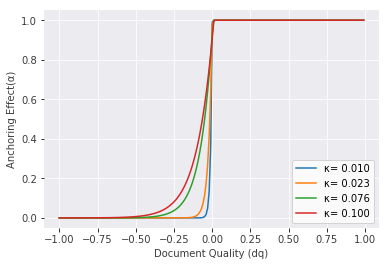

In [26]:
k_min = 0.010
k_dcg = 0.023
k_rbp = 0.076
k_max = 0.100

x = [i for i in np.arange(-1, 1, 0.01)]
y1 = []
y2 = []
y3 = []
y4 = []
for i in x:
    y1.append(min(1/(k_dcg + math.exp(-(1/k_dcg)*(i))), 1))
    y2.append(min(1/(k_rbp + math.exp(-(1/k_rbp)*(i))), 1))
    y3.append(min(1/(k_min + math.exp(-(1/k_min)*(i))), 1))
    y4.append(min(1/(k_max + math.exp(-(1/k_max)*(i))), 1))
    
#plt.figure(figsize=(14, 9))
plt.plot(x, y3, label = "κ= %.3f"%(k_min))
plt.plot(x, y1, label = "κ= %.3f"%(k_dcg))
plt.plot(x, y2, label = "κ= %.3f"%(k_rbp))
plt.plot(x, y4, label = "κ= %.3f"%(k_max))

ax = plt.gca()

ax.set_facecolor('#ECEBF0') # Set background-colour
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['bottom'].set_visible(False) #去掉下边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['right'].set_visible(False) #去掉右边框

plt.grid(c='#FFFFFF')
plt.xticks(color = "#3c3c3c")
plt.yticks(color = "#3c3c3c")

plt.xlabel('Document Quality (dq)', color = "#3c3c3c")
plt.ylabel('Anchoring Effect(α)', color = "#3c3c3c")

plt.legend(loc='lower right')
plt.savefig('kappa-compare.png', dpi=1100, bbox_inches='tight')

plt.show()

In [52]:
import matplotlib.pyplot as plt
import numpy as np   
import math
def f(i, k):
    if i > 0:
        return  1+ (1/math.exp(1)) * math.log(1+i)
    else:
        return 2 / (1 + math.exp(-k*i))
    
x = [i for i in np.arange(-1, 1, 0.01)]
y3 = [f(i, 5) for i in x]
y4 = [f(i, 3) for i in x]
y5 = [f(i, 1) for i in x]

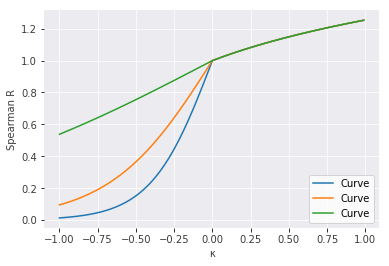

In [53]:
#plt.figure(figsize=(14, 9))
plt.plot(x, y3, label = "Curve")
plt.plot(x, y4, label = "Curve")
plt.plot(x, y5, label = "Curve")
ax = plt.gca()
ax.set_facecolor('#ECEBF0') # Set background-colour
ax.spines['top'].set_visible(False) #去掉上边框
ax.spines['bottom'].set_visible(False) #去掉下边框
ax.spines['left'].set_visible(False) #去掉左边框
ax.spines['right'].set_visible(False) #去掉右边框
plt.grid(c='#FFFFFF')
plt.xticks(color = "#3c3c3c")
plt.yticks(color = "#3c3c3c")
plt.xlabel('κ', color = "#3c3c3c")
plt.ylabel('Spearman R', color = "#3c3c3c")
plt.legend(loc='lower right')
plt.savefig('senstivity-compare.png', dpi=1100, bbox_inches='tight')
plt.show()

In [49]:
'''
Code for Parsing THUIR2 - Obsoleted
'''

DATA_FILE = "THUIR2/search_logs.xml"
REL_FILE = "THUIR2/relevance_annotation.tsv"

myParser = et.XMLParser(encoding="utf-8")
tree = et.parse(DATA_FILE, parser=myParser)
root = tree.getroot()


5.996851191404919e-33

In [35]:
'''
Read tsv data
'''

rel_data = pd.read_csv(REL_FILE, sep = '\t', header = 0, encoding='utf-8')

'''
Read XML data
'''

parsed_log = []
for session in root.iter("session"): 
    session_id = session.get("num")
    query_id = ""
    for query in session.iter("interaction"):
        page_id = query.get("page_id")
        if page_id == "1":
            if query_id:
                # Add record to log
                parsed_log.append({"id":session_id+"-"+query_id, "query": query_text, "result":query_result, "sat":query_sat, "nc": nc, "dc": dc}) 
            query_id = query.get("num")
            query_text = query.find("query").text
            query_result = []
            query_sat = query.find("query_satisfaction").get("score")
            nc = 0 # number of clicks
            dc = 0 # deepest click
        current_result = query.find("results")
        current_click = query.find("clicked")
        for result in current_result:
            doc_id = result.find("id").text
            doc_rank = result.get("rank")
            rel = rel_data[rel_data['docno'] == int(doc_id)]
            if len(rel):
                doc_rel = str(rel.iloc[0, 3])
            else:
                doc_rel = ''
            query_result.append({"doc_id":doc_id, "doc_rank":doc_rank, "doc_rel": doc_rel})
        if current_click:
            for click in current_click:
                nc += 1
                dc = click.find('rank').text
    # Add record to log
    parsed_log.append({"id":session_id+"-"+query_id, "query": query_text, "result":query_result, "sat":query_sat, "nc": nc, "dc": dc}) 
    
print(parsed_log[100])


4.0960000000000023e-07